In [1]:
import os
import gc
import copy
import time
import random
import string

# For data manipulation
import numpy as np
import pandas as pd

# Pytorch Imports
import torch
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
from torch.utils.data import Dataset, DataLoader
from torchvision.ops import sigmoid_focal_loss

# Utils
from tqdm import tqdm
from collections import defaultdict
import matplotlib.pyplot as plt

# Sklearn Imports
from sklearn import metrics
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

#Text Cleaning
from bs4 import BeautifulSoup
import re 

# For Transformer Models
from transformers import AutoTokenizer, AutoModel, AdamW

# Suppress warnings
import warnings
warnings.filterwarnings("ignore")

# For descriptive error messages
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"


In [2]:
torch.cuda.is_available()

True

In [3]:
df = pd.read_csv("input/train_data.csv", index_col=0)
df.head()

,sentence,label
0,Срыв сроков строительства зоопарка оценили в 1...,1
1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1
2,"Обвиняли в этом столичный акимат, который сорв...",1
3,Запуск циклотронного центра ядерной медицины н...,1
4,Сроки сдачи объекта несколько раз переносились.,1


0    1340
1     329
Name: label, dtype: int64


Text(0.5, 1.0, 'Distribution of Labels')

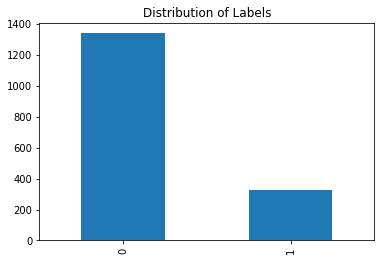

In [4]:
print(df['label'].value_counts())
df['label'].value_counts().plot.bar()
plt.title('Distribution of Labels')

In [5]:
CONFIG = {"seed": 2021,
          "epochs": 4,
          "model_name": "DeepPavlov/rubert-base-cased",
          "train_batch_size": 24,
          "valid_batch_size": 46,
          "max_length": 100,
          "learning_rate": 1e-5,
          "epsilon" : 1e-6,
          "weight_decay": 1e-5,
          "n_fold": 5,
          "num_classes": 1,
          "patience": 2,
          "device": torch.device("cuda:0" if torch.cuda.is_available() else "cpu"),
          }

CONFIG["tokenizer"] = AutoTokenizer.from_pretrained(CONFIG['model_name'])

In [6]:
def set_seed(seed=42):
    '''Sets the seed of the entire notebook so results are the same every time we run.
    This is for REPRODUCIBILITY.'''
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    # When running on the CuDNN backend, two further options must be set
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    # Set a fixed value for the hash seed
    os.environ['PYTHONHASHSEED'] = str(seed)
    
set_seed(CONFIG['seed'])

In [7]:
'''df_train, df_valid = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])'''

"df_train, df_valid = train_test_split(df, test_size=0.2, random_state=CONFIG['seed'])"

In [8]:
'''df_train = df_train.reset_index(drop=True)
df_valid = df_valid.reset_index(drop=True)'''

'df_train = df_train.reset_index(drop=True)\ndf_valid = df_valid.reset_index(drop=True)'

In [9]:
'''df_train.head()'''

'df_train.head()'

In [10]:
'''df_valid.head()'''

'df_valid.head()'

In [11]:
def text_cleaning(text):
    '''
    Cleans text into a basic form for NLP. Operations include the following:-
    1. Remove special charecters like &, #, etc
    2. Removes extra spaces
    3. Removes embedded URL links
    4. Removes HTML tags
    5. Removes emojis
    
    text - Text piece to be cleaned.
    '''
    template = re.compile(r'https?://\S+|www\.\S+') #Removes website links
    text = template.sub(r'', text)
    
    soup = BeautifulSoup(text, 'lxml') #Removes HTML tags
    only_text = soup.get_text()
    text = only_text
    
    emoji_pattern = re.compile("["
                               u"\U0001F600-\U0001F64F"  # emoticons
                               u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                               u"\U0001F680-\U0001F6FF"  # transport & map symbols
                               u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                               u"\U00002702-\U000027B0"
                               u"\U000024C2-\U0001F251"
                               "]+", flags=re.UNICODE)
    text = emoji_pattern.sub(r'', text)
    
    text = re.sub(' +', ' ', text) #Remove Extra Spaces
    text = text.strip() # remove spaces at the beginning and at the end of string

    return text

In [12]:
df.sentence = df.sentence.apply(text_cleaning)

In [13]:
df.sentence

0       Срыв сроков строительства зоопарка оценили в 1...
1       По данным Генпрокуратуры РФ, в 2014-2018 годах...
2       Обвиняли в этом столичный акимат, который сорв...
3       Запуск циклотронного центра ядерной медицины н...
4         Сроки сдачи объекта несколько раз переносились.
                              ...                        
1664    Подрядчик ООО «АльянсДорСтрой» должен сдать об...
1665    Он заявил, что запуск ракеты-носителя сверхтяж...
1666    Застройщик ЖК "Медовая Долина" планирует ввест...
1667    Официальные сроки, указанные в проектной декла...
1668    Он потребовал «выдержать намеченные сроки» стр...
Name: sentence, Length: 1669, dtype: object

In [14]:
skf = StratifiedKFold(n_splits=CONFIG['n_fold'], shuffle=True, random_state=CONFIG['seed'])

for fold, ( _, val_) in enumerate(skf.split(X=df.sentence, y=df.label)):
    df.loc[val_ , "kfold"] = int(fold)
    
df["kfold"] = df["kfold"].astype(int)
df.head()

,sentence,label,kfold
0,Срыв сроков строительства зоопарка оценили в 1...,1,4
1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1,3
2,"Обвиняли в этом столичный акимат, который сорв...",1,3
3,Запуск циклотронного центра ядерной медицины н...,1,4
4,Сроки сдачи объекта несколько раз переносились.,1,1


In [15]:
df

,sentence,label,kfold
0,Срыв сроков строительства зоопарка оценили в 1...,1,4
1,"По данным Генпрокуратуры РФ, в 2014-2018 годах...",1,3
2,"Обвиняли в этом столичный акимат, который сорв...",1,3
3,Запуск циклотронного центра ядерной медицины н...,1,4
4,Сроки сдачи объекта несколько раз переносились.,1,1
...,...,...,...
1664,Подрядчик ООО «АльянсДорСтрой» должен сдать об...,0,1
1665,"Он заявил, что запуск ракеты-носителя сверхтяж...",0,3
1666,"Застройщик ЖК ""Медовая Долина"" планирует ввест...",0,3
1667,"Официальные сроки, указанные в проектной декла...",0,2


In [16]:
'''class_counts = np.unique(df.label, return_counts=True)
class_counts
class_counts[1].sum()
[(class_counts[1].sum() - x)/ (x+1e-5) for i, x in enumerate(class_counts[1])]'''

'class_counts = np.unique(df.label, return_counts=True)\nclass_counts\nclass_counts[1].sum()\n[(class_counts[1].sum() - x)/ (x+1e-5) for i, x in enumerate(class_counts[1])]'

In [17]:
class SberNewsDataset(Dataset):
    def __init__(self, df, tokenizer, max_length):
        self.df = df
        self.max_len = max_length
        self.tokenizer = tokenizer
        self.text = df.sentence
        self.targets = df['label']
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, index):
        text = self.text[index]
        inputs = self.tokenizer.encode_plus(
                                text,
                                truncation=True,
                                add_special_tokens=True,
                                max_length=self.max_len,
                                padding='max_length',
                                return_token_type_ids=True
                            )
        target = np.array(self.targets[index])
        
        ids = inputs['input_ids']
        mask = inputs['attention_mask']
        token_type_ids = inputs["token_type_ids"]
        
        
        return {
            'ids': torch.tensor(ids, dtype=torch.int),
            'mask': torch.tensor(mask, dtype=torch.int),
            'token_type_ids': torch.tensor(token_type_ids, dtype=torch.int),
            'target': torch.tensor(target, dtype=torch.float)
        }


In [18]:
class SberNewsModel(nn.Module):
    def __init__(self, model_name):
        super(SberNewsModel, self).__init__()
        self.model = AutoModel.from_pretrained(model_name)
        self.drop = nn.Dropout(p=0.2)
        self.fc = nn.Linear(768, CONFIG['num_classes'])
        
    def forward(self, ids, mask, token_type_ids):
        _, features = self.model(input_ids=ids, attention_mask=mask, token_type_ids = token_type_ids, return_dict=False)
        out = self.drop(features)
        outputs = self.fc(out)
        
        return outputs.squeeze()

In [25]:
def criterion(outputs, targets):
    return torch.nn.BCEWithLogitsLoss()(outputs, targets)

In [28]:
def train_one_epoch(model, optimizer, dataloader, device, epoch):
    model.train()
    
    dataset_size = 0
    running_loss = 0.0
    
    #Automatic Mixed Precision
    scaler = torch.cuda.amp.GradScaler()
    #------------------
    
    score_batch = []
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:
            
        
        ids = data['ids'].to(device, dtype = torch.int)
        mask = data['mask'].to(device, dtype = torch.int)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.int)
        targets = data['target'].to(device, dtype=torch.float)

        batch_size = ids.size(0)

        #Automatic Mixed Precision
        with torch.cuda.amp.autocast():
        #------------------
            outputs = model(ids, mask, token_type_ids)
            
            #print(outputs)
            #print(targets)
            
            loss = criterion(outputs, targets)
            
            
        
        #Automatic Mixed Precision
        scaler.scale(loss).backward()
        #------------------

                
        #optimizer.step()
            
        #Automatic Mixed Precision
        scaler.step(optimizer)
        scaler.update()
        #------------------
        optimizer.zero_grad()
 
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size

        epoch_loss = running_loss / dataset_size

        bar.set_postfix(Epoch=epoch, Train_Loss=epoch_loss,
                            LR=optimizer.param_groups[0]['lr'])
    gc.collect()
    return epoch_loss


In [29]:
@torch.no_grad()
def valid_one_epoch(model, dataloader, device, epoch):
    model.eval()
    
    dataset_size = 0
    running_loss = 0.0
    
    accuracy_batch = []
    balanced_accuracy_score_batch = []
    
    epoch_targets=[]
    epoch_outputs=[]
    
    bar = tqdm(enumerate(dataloader), total=len(dataloader))
    for step, data in bar:        
        ids = data['ids'].to(device, dtype = torch.int)
        mask = data['mask'].to(device, dtype = torch.int)
        token_type_ids = data['token_type_ids'].to(device, dtype = torch.int)
        targets = data['target'].to(device, dtype=torch.float)
        
        batch_size = ids.size(0)

        outputs = model(ids, mask, token_type_ids)
        
        loss = criterion(outputs, targets)
        
        #print(f"outputs ({outputs})")
        epoch_targets.extend(targets.cpu().detach().numpy().tolist())
        epoch_outputs.extend(torch.sigmoid(outputs).cpu().detach().numpy().tolist())
        
        #print(f"out_detach_sigmoid ({out_detach_sigmoid})")
        #print(f"targets_detach ({targets_detach})")
        
        #print(f"accuracy_batch ({accuracy_batch})")
        
        running_loss += (loss.item() * batch_size)
        dataset_size += batch_size
        
        epoch_loss = running_loss / dataset_size
        
        epoch_accuracy = np.mean(accuracy_batch)
        epoch_balanced_accuracy_score = np.mean(balanced_accuracy_score_batch)
        
        bar.set_postfix(Epoch=epoch, Valid_Loss=epoch_loss,
                        LR=optimizer.param_groups[0]['lr'])   
    
    gc.collect()
    return epoch_loss, epoch_outputs, epoch_targets


In [30]:
def run_training(model, optimizer, device, num_epochs, fold):
    
    if torch.cuda.is_available():
        print("[INFO] Using GPU: {}\n".format(torch.cuda.get_device_name()))
    
    start = time.time()
    best_model_wts = copy.deepcopy(model.state_dict())
    best_epoch_loss = np.inf
    history = defaultdict(list)
    
    epochs_no_improve = 0
    
    for epoch in range(1, num_epochs + 1): 
        gc.collect()
        train_epoch_loss = train_one_epoch(model, optimizer,  
                                           dataloader=train_loader, 
                                           device=CONFIG['device'], epoch=epoch)
        
        val_epoch_loss, epoch_outputs, epoch_targets = valid_one_epoch(model, valid_loader, device=CONFIG['device'], 
                                         epoch=epoch)
        #print(f"Validation epoch_outputs ({epoch_outputs})")
        #print(f"Validation epoch_targets ({epoch_targets})")
        
        roc_auc_score = metrics.roc_auc_score(epoch_targets, epoch_outputs)
        
        epoch_outputs = np.array(epoch_outputs) >= 0.5
        accuracy_score = metrics.accuracy_score(epoch_targets, epoch_outputs)
        balanced_accuracy_score = metrics.balanced_accuracy_score(epoch_targets, epoch_outputs)
        f1_score = metrics.f1_score(epoch_targets, epoch_outputs)
        recall_score = metrics.recall_score(epoch_targets, epoch_outputs)
        precision_score = metrics.precision_score(epoch_targets, epoch_outputs)
    
        history['Train Loss'].append(train_epoch_loss)
        history['Valid Loss'].append(val_epoch_loss)
        print(f"Validation roc auc score ({roc_auc_score})")
        print(f"Validation accuracy ({accuracy_score})")
        print(f"Validation balanced accuracy score ({balanced_accuracy_score})")
        print(f"Validation f1 score ({f1_score})")
        print(f"Validation recall score ({recall_score})")
        print(f"Validation precision score ({precision_score})")
        
        
        # deep copy the model
        if val_epoch_loss <= best_epoch_loss:
            print(f"Validation Loss Improved ({best_epoch_loss} ---> {val_epoch_loss})")
            best_epoch_loss = val_epoch_loss
            history["Best Loss"].append(best_epoch_loss)
            best_model_wts = copy.deepcopy(model.state_dict())
            PATH = f"Loss-Fold-{fold}.bin"
            torch.save(model.state_dict(), PATH)
            # Save a model file from the current directory
            print(f"Model Saved")
        else:
            epochs_no_improve += 1
            if epochs_no_improve >= CONFIG["patience"]:
                print('Early stopping!' )
                print()
                break
            
        print()
    
    end = time.time()
    time_elapsed = end - start
    print('Training complete in {:.0f}h {:.0f}m {:.0f}s'.format(
        time_elapsed // 3600, (time_elapsed % 3600) // 60, (time_elapsed % 3600) % 60))
    print("Best Loss: {:.4f}".format(best_epoch_loss))
    
    # load best model weights
    model.load_state_dict(best_model_wts)
    
    return model, history

In [31]:
def prepare_loaders():
    df_train = df[df.kfold != fold].reset_index(drop=True)
    df_valid = df[df.kfold == fold].reset_index(drop=True)
    
    train_dataset = SberNewsDataset(df_train, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])
    valid_dataset = SberNewsDataset(df_valid, tokenizer=CONFIG['tokenizer'], max_length=CONFIG['max_length'])

    train_loader = DataLoader(train_dataset, batch_size=CONFIG['train_batch_size'], 
                              num_workers=2, shuffle=True, pin_memory=True)
    valid_loader = DataLoader(valid_dataset, batch_size=CONFIG['valid_batch_size'], 
                              num_workers=2, shuffle=False, pin_memory=True)
    
    return train_loader, valid_loader

In [32]:
for fold in range(0, CONFIG['n_fold']):
    print(f"====== Fold: {fold} ======")
    
    # Create Dataloaders
    train_loader, valid_loader = prepare_loaders()
    
    model = SberNewsModel(CONFIG['model_name'])
    model.to(CONFIG['device'])
    
    # Define Optimizer and Scheduler
    optimizer = AdamW(model.parameters(), lr=CONFIG['learning_rate'], eps=CONFIG['epsilon'], weight_decay=CONFIG['weight_decay'])
    
    model, history = run_training(model, optimizer,
                                  device=CONFIG['device'],
                                  num_epochs=CONFIG['epochs'],
                                  fold=fold)
    
    
    del model, history, train_loader, valid_loader
    _ = gc.collect()
    print()
    

====== Fold: 0 ======


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA GeForce RTX 2080



100%|██████████| 8/8 [00:01<00:00,  7.63it/s, Epoch=1, LR=1e-5, Valid_Loss=0.46]


Validation roc auc score (0.8381388511985527)
Validation accuracy (0.8023952095808383)
Validation balanced accuracy score (0.5)
Validation f1 score (0.0)
Validation recall score (0.0)
Validation precision score (0.0)
Validation Loss Improved (inf ---> 0.46039692495397466)
Model Saved



100%|██████████| 8/8 [00:01<00:00,  7.68it/s, Epoch=2, LR=1e-5, Valid_Loss=0.32]


Validation roc auc score (0.9238466757123472)
Validation accuracy (0.8652694610778443)
Validation balanced accuracy score (0.8874943464495704)
Validation f1 score (0.7305389221556886)
Validation recall score (0.9242424242424242)
Validation precision score (0.6039603960396039)
Validation Loss Improved (0.46039692495397466 ---> 0.3198052727265986)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.24it/s, Epoch=3, LR=1e-5, Valid_Loss=0.283]


Validation roc auc score (0.9193803708729081)
Validation accuracy (0.8982035928143712)
Validation balanced accuracy score (0.8908864767073723)
Validation f1 score (0.7733333333333333)
Validation recall score (0.8787878787878788)
Validation precision score (0.6904761904761905)
Validation Loss Improved (0.3198052727265986 ---> 0.28331830457388285)
Model Saved



100%|███████████| 8/8 [00:01<00:00,  7.58it/s, Epoch=4, LR=1e-5, Valid_Loss=0.3]


Validation roc auc score (0.923168249660787)
Validation accuracy (0.907185628742515)
Validation balanced accuracy score (0.8907734056987788)
Validation f1 score (0.786206896551724)
Validation recall score (0.8636363636363636)
Validation precision score (0.7215189873417721)

Training complete in 0h 0m 51s
Best Loss: 0.2833

====== Fold: 1 ======


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA GeForce RTX 2080



100%|█████████| 8/8 [00:01<00:00,  7.58it/s, Epoch=1, LR=1e-5, Valid_Loss=0.482]


Validation roc auc score (0.6865671641791045)
Validation accuracy (0.8023952095808383)
Validation balanced accuracy score (0.5)
Validation f1 score (0.0)
Validation recall score (0.0)
Validation precision score (0.0)
Validation Loss Improved (inf ---> 0.481662784240203)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.41it/s, Epoch=2, LR=1e-5, Valid_Loss=0.427]


Validation roc auc score (0.8430574400723654)
Validation accuracy (0.8023952095808383)
Validation balanced accuracy score (0.5)
Validation f1 score (0.0)
Validation recall score (0.0)
Validation precision score (0.0)
Validation Loss Improved (0.481662784240203 ---> 0.4273407635039198)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.30it/s, Epoch=3, LR=1e-5, Valid_Loss=0.305]


Validation roc auc score (0.9114654002713705)
Validation accuracy (0.8532934131736527)
Validation balanced accuracy score (0.6858887381275441)
Validation f1 score (0.5242718446601942)
Validation recall score (0.4090909090909091)
Validation precision score (0.7297297297297297)
Validation Loss Improved (0.4273407635039198 ---> 0.3053062626657015)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.54it/s, Epoch=4, LR=1e-5, Valid_Loss=0.267]


Validation roc auc score (0.9408638625056536)
Validation accuracy (0.8862275449101796)
Validation balanced accuracy score (0.8662935323383085)
Validation f1 score (0.7432432432432432)
Validation recall score (0.8333333333333334)
Validation precision score (0.6707317073170732)
Validation Loss Improved (0.3053062626657015 ---> 0.26670397686476477)
Model Saved

Training complete in 0h 0m 53s
Best Loss: 0.2667

====== Fold: 2 ======


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA GeForce RTX 2080



100%|█████████| 8/8 [00:01<00:00,  7.61it/s, Epoch=1, LR=1e-5, Valid_Loss=0.471]


Validation roc auc score (0.7563319764812303)
Validation accuracy (0.8023952095808383)
Validation balanced accuracy score (0.5)
Validation f1 score (0.0)
Validation recall score (0.0)
Validation precision score (0.0)
Validation Loss Improved (inf ---> 0.47099087489936164)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.52it/s, Epoch=2, LR=1e-5, Valid_Loss=0.389]


Validation roc auc score (0.8983491632745364)
Validation accuracy (0.8802395209580839)
Validation balanced accuracy score (0.7426503844414292)
Validation f1 score (0.6296296296296297)
Validation recall score (0.5151515151515151)
Validation precision score (0.8095238095238095)
Validation Loss Improved (0.47099087489936164 ---> 0.388818207793607)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.45it/s, Epoch=3, LR=1e-5, Valid_Loss=0.261]


Validation roc auc score (0.945273631840796)
Validation accuracy (0.8892215568862275)
Validation balanced accuracy score (0.8681592039800996)
Validation f1 score (0.7482993197278912)
Validation recall score (0.8333333333333334)
Validation precision score (0.6790123456790124)
Validation Loss Improved (0.388818207793607 ---> 0.261020995944203)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.48it/s, Epoch=4, LR=1e-5, Valid_Loss=0.244]


Validation roc auc score (0.9561849841700588)
Validation accuracy (0.9011976047904192)
Validation balanced accuracy score (0.8527815468113975)
Validation f1 score (0.7555555555555555)
Validation recall score (0.7727272727272727)
Validation precision score (0.7391304347826086)
Validation Loss Improved (0.261020995944203 ---> 0.24361817632428187)
Model Saved

Training complete in 0h 0m 53s
Best Loss: 0.2436

====== Fold: 3 ======


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA GeForce RTX 2080



100%|█████████| 8/8 [00:01<00:00,  7.18it/s, Epoch=1, LR=1e-5, Valid_Loss=0.443]


Validation roc auc score (0.8726255088195387)
Validation accuracy (0.8023952095808383)
Validation balanced accuracy score (0.5)
Validation f1 score (0.0)
Validation recall score (0.0)
Validation precision score (0.0)
Validation Loss Improved (inf ---> 0.44295251458704826)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.46it/s, Epoch=2, LR=1e-5, Valid_Loss=0.182]


Validation roc auc score (0.9708842152872003)
Validation accuracy (0.9461077844311377)
Validation balanced accuracy score (0.8921867933061962)
Validation f1 score (0.8548387096774194)
Validation recall score (0.803030303030303)
Validation precision score (0.9137931034482759)
Validation Loss Improved (0.44295251458704826 ---> 0.18180844516766642)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.35it/s, Epoch=3, LR=1e-5, Valid_Loss=0.171]


Validation roc auc score (0.9692446856625961)
Validation accuracy (0.9431137724550899)
Validation balanced accuracy score (0.8846110357304386)
Validation f1 score (0.8455284552845528)
Validation recall score (0.7878787878787878)
Validation precision score (0.9122807017543859)
Validation Loss Improved (0.18180844516766642 ---> 0.17148036426100546)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.49it/s, Epoch=4, LR=1e-5, Valid_Loss=0.205]


Validation roc auc score (0.9717322478516509)
Validation accuracy (0.9221556886227545)
Validation balanced accuracy score (0.8315807327001357)
Validation f1 score (0.7758620689655172)
Validation recall score (0.6818181818181818)
Validation precision score (0.9)

Training complete in 0h 0m 52s
Best Loss: 0.1715

====== Fold: 4 ======


Some weights of the model checkpoint at DeepPavlov/rubert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


[INFO] Using GPU: NVIDIA GeForce RTX 2080



100%|█████████| 8/8 [00:01<00:00,  7.58it/s, Epoch=1, LR=1e-5, Valid_Loss=0.466]


Validation roc auc score (0.7184270952927669)
Validation accuracy (0.8048048048048048)
Validation balanced accuracy score (0.5)
Validation f1 score (0.0)
Validation recall score (0.0)
Validation precision score (0.0)
Validation Loss Improved (inf ---> 0.46603504011222907)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.47it/s, Epoch=2, LR=1e-5, Valid_Loss=0.381]


Validation roc auc score (0.8574052812858783)
Validation accuracy (0.8048048048048048)
Validation balanced accuracy score (0.5)
Validation f1 score (0.0)
Validation recall score (0.0)
Validation precision score (0.0)
Validation Loss Improved (0.46603504011222907 ---> 0.38088884260561373)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.57it/s, Epoch=3, LR=1e-5, Valid_Loss=0.298]


Validation roc auc score (0.9058553386911598)
Validation accuracy (0.8648648648648649)
Validation balanced accuracy score (0.8286452353616534)
Validation f1 score (0.6896551724137931)
Validation recall score (0.7692307692307693)
Validation precision score (0.625)
Validation Loss Improved (0.38088884260561373 ---> 0.2976928505901102)
Model Saved



100%|█████████| 8/8 [00:01<00:00,  7.61it/s, Epoch=4, LR=1e-5, Valid_Loss=0.305]

Validation roc auc score (0.9225602755453501)
Validation accuracy (0.8648648648648649)
Validation balanced accuracy score (0.8519517795637199)
Validation f1 score (0.7058823529411765)
Validation recall score (0.8307692307692308)
Validation precision score (0.6136363636363636)

Training complete in 0h 0m 51s
Best Loss: 0.2977

